# IMAGE CLASSIFICATION FOR AMERICAN SIGN LANGUAGE (ASL)

This project is to classified each ASL sign language with it's respective classes. There are 24 classes excluding J and Z as they are motion gesture. In this project, we are going to use our own set of captured data and train our own model to detect ASL sign language. 

# Setup

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# most import image processing library, OpenCV as cv2
import cv2
from imutils.paths import list_images

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

In [42]:
# File directory to the training folder.
# Follow the config setup in the image collection notebook, or your own folder,
# consisting of one "train" folder, and one "test" folder
IMAGE_DIR = "dataset"
# directory to the train set images
TRAIN_DIR = os.path.join(IMAGE_DIR, "train")
# directory to the train set images
# NOTE: these images will not be touched during training
#  to avoid data leakage
TEST_DIR = os.path.join(IMAGE_DIR, "test")

# number of classes = 24 not including 'J' and 'Z' as they are motion gesture
CLASS_NAMES = ["A", "B", "C", "D", "E", "F", "G", "H", "I", 
               "K", "L", "M", "N", "O", "P", "Q", "R",
               "S", "T", "U", "V", "W", "X", "Y"]

dataset\train\A\55A.jpg


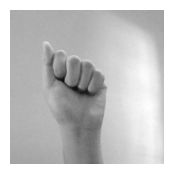

dataset\train\B\97B.jpg


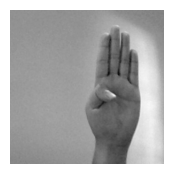

dataset\train\C\141C.jpg


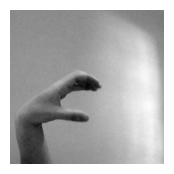

dataset\train\D\270D.jpg


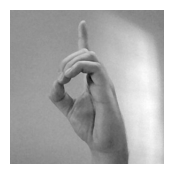

dataset\train\E\aug_1218_1694829.jpg


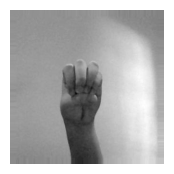

dataset\train\F\F_1.jpg


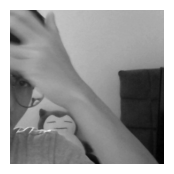

dataset\train\G\89G.jpg


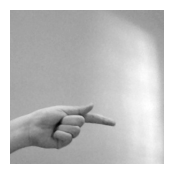

dataset\train\H\290H.jpg


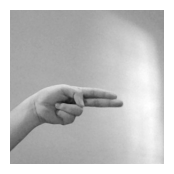

dataset\train\I\176I.jpg


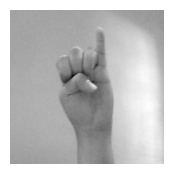

dataset\train\K\121K.jpg


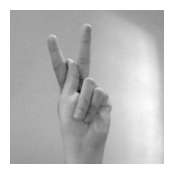

dataset\train\L\aug_3027_1248446.jpg


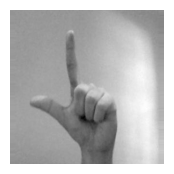

dataset\train\M\220M.jpg


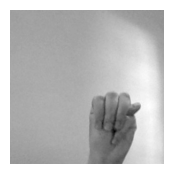

dataset\train\N\256N.jpg


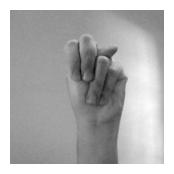

dataset\train\O\aug_4095_955844.jpg


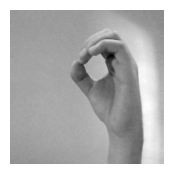

dataset\train\P\28P.jpg


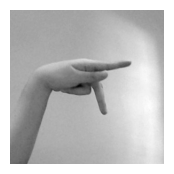

dataset\train\Q\aug_4569_2889456.jpg


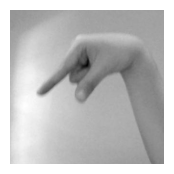

dataset\train\R\244R.jpg


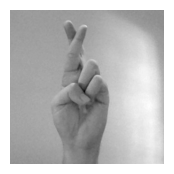

dataset\train\S\248S.jpg


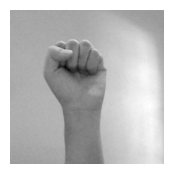

dataset\train\T\74T.jpg


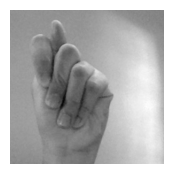

dataset\train\U\89U.jpg


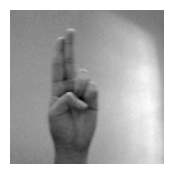

dataset\train\V\193V.jpg


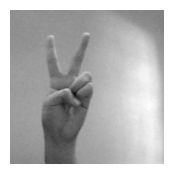

dataset\train\W\21W.jpg


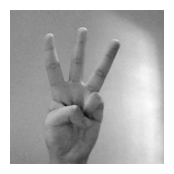

dataset\train\X\279X.jpg


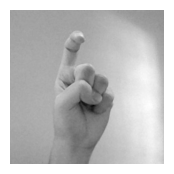

dataset\train\Y\149Y.jpg


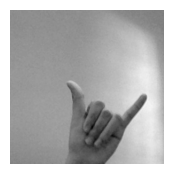

In [38]:
for i in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, i)
    img_paths = list(list_images(class_path))
    # checking one random image from each class
    for img_path in np.random.choice(img_paths, 1):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(2, 2))
        plt.axis('off')
        plt.imshow(img, cmap="gray")
        plt.show()

In [29]:
# checking the shape of the image
# (height, width, channel)
# 1 channel for grayscale images, but not shown at the 3rd dimension here
# because we loaded the image using OpenCV in grayscale mode
print(img.shape)

(320, 320)


resized_img.shape = (50, 50)


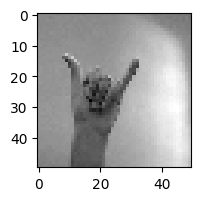

In [32]:
## Showing how to resize image
IMG_SIZE = 50

resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
print(f"resized_img.shape = {resized_img.shape}")
plt.figure(figsize=(2, 2))
plt.imshow(resized_img, cmap = 'gray')
plt.show()

# Creating dataset and showing data augmentation

`ImageDataGenerator` class is generally the easiest method to use to load and augment image datasets. Therefore, we would start with this simplest approach first.

Later, we will use a more advanced method using `tf.data` API, which will result in much faster training and inference times, at the cost of slightly more complex and longer code.

In [87]:
BATCH_SIZE = 32 # Number of training examples used in one iteration of training
IMG_HEIGHT = 80 # height of image to resize to
IMG_WIDTH = 80 # width of image to resize to

In [88]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(list_images(TRAIN_DIR)))
totalTest = len(list(list_images(TEST_DIR)))

# initialize the training data augmentation object
# this will create images with different characteristics
#  ON THE FLY during training
trainAug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    # validation split is very important to ensure we
    #  have validation data during training
    validation_split=0.2
)

# initialize the validation/testing data augmentation object
testAug = ImageDataGenerator()

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    TRAIN_DIR,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

# initialize the testing generator
testGen = testAug.flow_from_directory(
    TEST_DIR,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="grayscale",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 8508 images belonging to 24 classes.
Found 4021 images belonging to 24 classes.


In [89]:
# take the first batch of images and labels
batch_images, batch_labels = next(trainGen)
print(batch_images.shape)
print(batch_labels.shape)

(32, 80, 80, 1)
(32, 24)


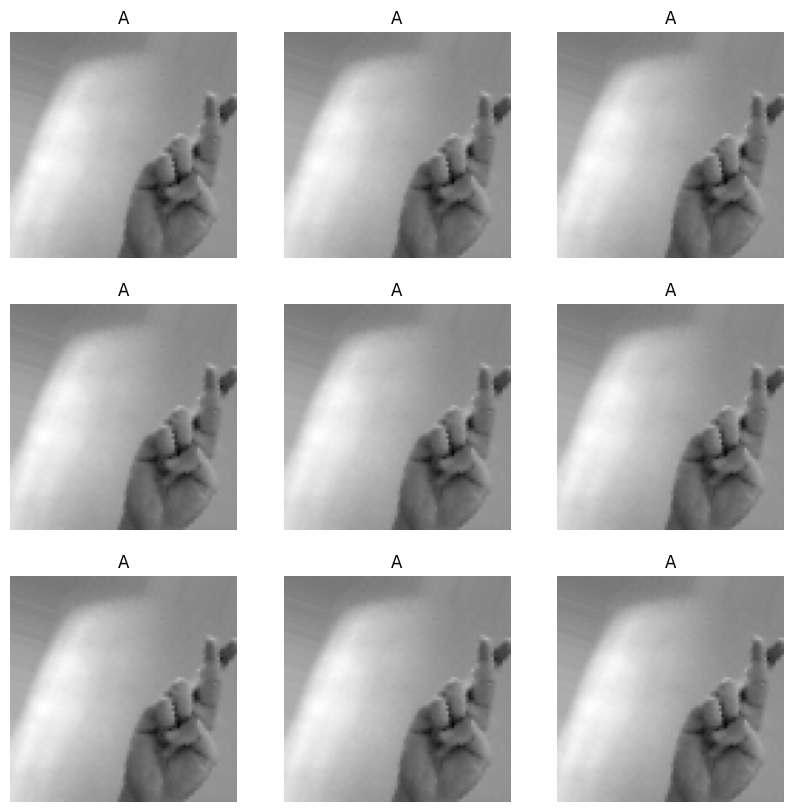

In [93]:
## Showing a batch of images with labels

plt.figure(figsize=(10,10))
i = 0
for img, label in zip(batch_images, batch_labels):
    # show only 9 images
    while i < 9:
        # with 3 rows and 3 columns
        ax = plt.subplot(3, 3, i+1)
        # show in grayscale
        plt.imshow(img, cmap = 'gray')
        # add the label name on top
        plt.title(CLASS_NAMES[int(labels[i])])
        plt.axis('off')
        i += 1
plt.show()

In [94]:
# resets the generator to the first batch after we have checked the first batch
trainGen.reset()

# CREATE MODEL & COMPILE THE MODEL

In [107]:
num_classes = len(CLASS_NAMES)

def create_model():
    model = Sequential([
        #1st conv block
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #2nd conv block
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #3rd conv block
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),

        #4th conv block
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        # the last layer must follow the number of classes available
        layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000012ED4C59E80>>

# COMPILE THE MODEL

In [108]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_35 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 7, 7, 128)       

# TRAIN THE MODEL

In [110]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = create_model()

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [cp_callback],
    epochs=epochs)

Epoch 1/10
210/210 [==============================] - 14s 66ms/step - loss: 3.0489 - accuracy: 0.0808 - val_loss: 2.1552 - val_accuracy: 0.3321

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/10
210/210 [==============================] - 15s 72ms/step - loss: 1.4418 - accuracy: 0.5379 - val_loss: 0.8078 - val_accuracy: 0.7226

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/10
210/210 [==============================] - 14s 68ms/step - loss: 0.5673 - accuracy: 0.8210 - val_loss: 0.3551 - val_accuracy: 0.8893

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/10
210/210 [==============================] - 13s 63ms/step - loss: 0.2831 - accuracy: 0.9161 - val_loss: 0.2262 - val_accuracy: 0.9268

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/10
210/210 [==============================] - 13s 61ms/step - loss: 0.1544 - accuracy: 0.9534 - val_loss: 0.1915 - val_accuracy: 0.9333

Epoch 00005: saving model to training_1\cp.ckpt
Epoch 6/10
210/210 [===============

In [111]:
!ls {checkpoint_dir}

checkpoint
cp.ckpt.data-00000-of-00001
cp.ckpt.index


# VISUALIZE TRAINING RESULTS

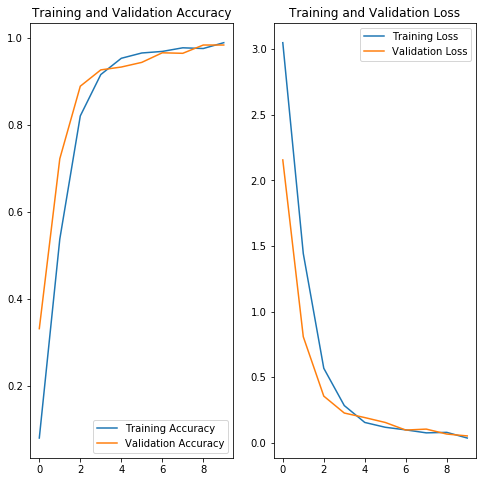

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# TESTING FOR 1ST TRAINING

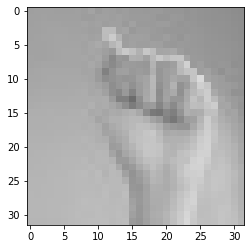

This image most likely belongs to A with a 99.96 percent confidence.


In [117]:
#testing

testing_url = "https://drive.google.com/file/d/1IO_wBmp2Z7ebD76k32_e81I6BmsEXylb/view?usp=sharing"
testing_path ='./handgestures/test/A/75A.jpg'


img = keras.preprocessing.image.load_img(
    testing_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)


# DROPOUT

#### This section is used when there is an overfitting data.

In [118]:
def create_model2():
    model = Sequential([
                    
        layers.experimental.preprocessing.Rescaling(1./255),

        #1st conv block
        layers.Conv2D(32, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #2nd conv block
        layers.Conv2D(64, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        #3rd conv block
        layers.Conv2D(128, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),
        
        #4th conv block
        layers.Conv2D(256, (3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,1),
        
        #ANN Block
        layers.Flatten(input_shape=[32, 32]),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), 
        #Incase there is an overfit data during the first training, remove # and apply dropout.
        #This will 

        #output layer
        layers.Dense(25, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_37 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 7, 7, 128)       

In [119]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_37 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 7, 7, 128)       

#### 2nd Training after applying Dropout

In [121]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = create_model2()

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [cp_callback],
    epochs=epochs)

Epoch 1/10
210/210 [==============================] - 15s 71ms/step - loss: 3.2077 - accuracy: 0.0429 - val_loss: 3.1870 - val_accuracy: 0.0369

Epoch 00001: saving model to training_2\cp.ckpt
Epoch 2/10
210/210 [==============================] - 14s 67ms/step - loss: 3.1915 - accuracy: 0.0427 - val_loss: 3.1802 - val_accuracy: 0.0387

Epoch 00002: saving model to training_2\cp.ckpt
Epoch 3/10
210/210 [==============================] - 13s 61ms/step - loss: 2.9214 - accuracy: 0.1068 - val_loss: 2.2595 - val_accuracy: 0.3208

Epoch 00003: saving model to training_2\cp.ckpt
Epoch 4/10
210/210 [==============================] - 13s 62ms/step - loss: 1.9761 - accuracy: 0.3772 - val_loss: 1.2943 - val_accuracy: 0.6274

Epoch 00004: saving model to training_2\cp.ckpt
Epoch 5/10
210/210 [==============================] - 13s 60ms/step - loss: 1.2890 - accuracy: 0.5692 - val_loss: 0.7245 - val_accuracy: 0.7976

Epoch 00005: saving model to training_2\cp.ckpt
Epoch 6/10
210/210 [===============

# TESTING FOR 2ND TRAINING AFTER DROPOUT

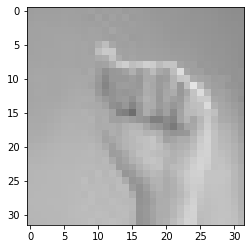

This image most likely belongs to A with a 10.17 percent confidence.


In [122]:
#testing

testing_url = "https://drive.google.com/file/d/1IO_wBmp2Z7ebD76k32_e81I6BmsEXylb/view?usp=sharing"
testing_path ='./handgestures/test/A/150A.jpg'


img = keras.preprocessing.image.load_img(
    testing_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)
plt.show()

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)


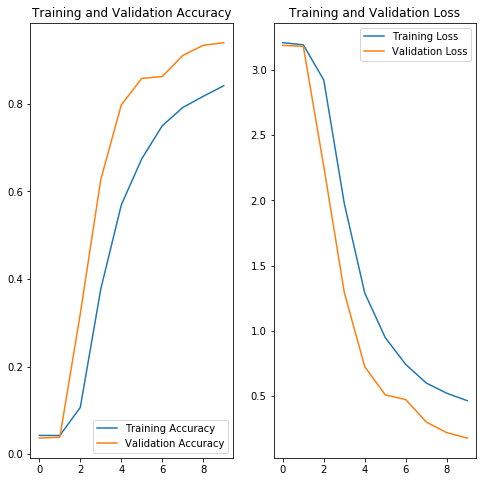

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# REFERENCE

#### WEBSITE

1. https://www.tensorflow.org/api_docs/python/tf/keras/Model
2. https://keras.io/api/
3. https://deepai.org/machine-learning-glossary-and-terms/sigmoid-function
4. https://towardsdatascience.com/multi-layer-neural-networks-with-sigmoid-function-deep-learning-for-rookies-2-bf464f09eb7f
5. https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb
6. https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
7. https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/
8. https://www.tensorflow.org/tutorials/images/classification
9. https://www.freecodecamp.org/news/weekend-projects-sign-language-and-static-gesture-recognition-using-scikit-learn-60813d600e79/
10. https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/blob/master/dataset/pipeline_final.ipynb
11. https://towardsdatascience.com/basics-of-image-classification-with-keras-43779a299c8b
12. https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

#### YOUTUBE

1. https://youtu.be/j-3vuBynnOE
2. https://youtu.be/WvoLTXIjBYU
3. https://youtu.be/pDXdlXlaCco
4. https://www.youtube.com/watch?v=HxtBIwfy0kM